In [1]:
%load_ext autoreload
% autoreload 2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='serif')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from geant_dataloader import rtnpy_load_data
from logistics import *
import random
import datetime
import os

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)
print(torch.__version__)

0.4.0a0+200fb22


In [86]:
#currently working on 32 x32 implementation


torch.manual_seed(423312)
imageSize = 32
batchSize = 64
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
norm_scale = 'none'
epoch=0 #will be updated during the run
num_epochs = 30
nc =1
ndf = 64
ngf = 64
zdim = 25
log_interval = 100

In [87]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
    
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        

('Random Seed: ', 25)
Using Cuda
cuda:1
('Using:', 'gpu', 0L)


In [88]:
#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", num_events = 100, image_size = imageSize)
#image_array1 = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_15000Events_64OldSize_32NewSize.npy", num_events = None, image_size = imageSize)
image_array = rtnpy_load_data("numpy_data/geant4Data_30000Events_"+str(imageSize)+"ImageSize_800MeV_ScintiAbsoThickness75_8.npz", num_events = None, image_size = imageSize)
#image_array=np.concatenate((image_array1, image_array2),0)

In [89]:
print image_array.shape


(30000, 1, 32, 32)


In [90]:
#print norm_scale
normed_array, scale = normalize(image_array, norm_scale = norm_scale )

tensor_array_train = torch.stack([torch.Tensor(i) for i in normed_array[:20000]])
tensor_data_train = torch.utils.data.TensorDataset(tensor_array_train)
tensor_array_test = torch.stack([torch.Tensor(i) for i in normed_array[20000:]])
tensor_data_test = torch.utils.data.TensorDataset(tensor_array_test)

train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size=batchSize, num_workers=8)
test_loader = torch.utils.data.DataLoader(tensor_data_test, batch_size = batchSize, num_workers = 8)
print(train_loader)

In [91]:
def to_img(x, norm_scale = norm_scale, scale = scale, imageSize=imageSize):
    x = x.cpu().data.numpy()
    #x = 0.5 * (x + 1)
   # print x
   # x = np.clip(x, 0, 1)
    
    # this just drops the channel axis
    x = x.reshape([-1, imageSize, imageSize])

    x = unnormalize(x, scale = scale, norm_scale = norm_scale)
    #print x.max()
    
    return x

def plot_reconstructions(model, save_dir=None, epoch = epoch, latent_dim = zdim, conv=False, simple=False, n=4, imageSize=imageSize, norm_scale = norm_scale, batchSize = batchSize, scale = scale):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    """
    # encode then decode
    data= next(iter(test_loader))
    #print(data[0].shape)
    #print norm_scale
    if not conv:
        data = data[0].view([-1, 1024])
    #data = Variable(data, volatile=True)
    true_imgs = data
    #print true_imgs.shape
    decoded_imgs, _, _ = model.forward(data.to(device))
    #print encoded_imgs.shape
    #if simple:
    #    encoded_imgs = F.relu(encoded_imgs)
    #print(encoded_imgs.shape)    
    #decoded_imgs = model.forward(encoded_imgs)
    #print(decoded_imgs)
    true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
    decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)
    #print(decoded_imgs.shape)
    
    rowsize = n * 2.5
    columnsize = 4
    fig, axn = plt.subplots(figsize=(rowsize, columnsize))
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.98, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)

        if i == 0:
            im = plt.imshow(true_imgs[i], cmap=cmap)
        else: 
            plt.imshow(true_imgs[i], cmap=cmap)
        #if i == 0:
        #    ax.set_ylabel("Real")
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        if i == 0:
            ax.set_ylabel("Real", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.25,0.5)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i], cmap=cmap)
        print(decoded_imgs[i].min(), decoded_imgs[i].max())
        if i == 0:
            ax.set_ylabel("Decoded", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.3,0.5)

        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        

    plt.tight_layout()

    cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    fig.subplots_adjust(wspace=-0.185, hspace=0.09)
    fig.suptitle(r"VAE Real and Decoded Samples of $e^{-}$ $E_{dep}$, "+ str(latent_dim) + " Latent Dim ", x=0.52, y = 1.02)
          
    if save_dir != None:
        #learning_rate = '%.0E' % Decimal(lr)
      
        filename = "VAE_EdepFor" + str(n) + "Events_" + str(latent_dim) +"latentDim_"+ str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize"
 
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    
    return

In [136]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(1024, 400)
        self.fc21 = nn.Linear(400, zdim)
        self.fc22 = nn.Linear(400, zdim)
        self.fc3 = nn.Linear(zdim, 400)
        self.fc4 = nn.Linear(400, 1024)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.leaky_relu(self.fc4(h3), 0.05)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 1024))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1024), size_average=False)
    MSE = F.mse_loss(recon_x, x.view(-1,1024), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data) in enumerate(train_loader,):
        data = data[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data) in enumerate(test_loader,0):
            data = data[0].to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batchSize, 1, 32, 32)[:n]])
                #save_image(comparison.cpu(),
                #         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))




In [ ]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/VAE/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
#mydir = None
if mydir != None:
    try:
        os.makedirs(mydir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

    with open(mydir + 'NetworkInfo.txt', 'w') as f:
        print >> f, 'model:', model
        print >> f, 'normalization scale:', norm_scale
        print >> f, 'latent dimensionality:', zdim
        print >> f, 'image height/width:', imageSize
        print >> f, 'loss function: MSE + KL div'



for epoch in range(1, num_epochs + 1):
    if epoch % 5 == 1:
        plot_reconstructions(model, save_dir=mydir, conv=False, simple=False, n=5, epoch = epoch)
    train(epoch)
    test(epoch)
#    with torch.no_grad():
#        sample = torch.randn(64, zdim).to(device)
#        sample = model.decode(sample).cpu()
#         save_image(sample.view(64, 1, 64, 64),
#                    'results/sample_' + str(epoch) + '.png')

(-0.20109224, 28.866426)
(-0.104902506, 33.496742)
(-0.12316463, 53.77243)
(-0.16204727, 28.507402)
(-0.18351805, 19.522852)
(-0.11603886, 22.39465)
(-0.100432985, 21.507748)


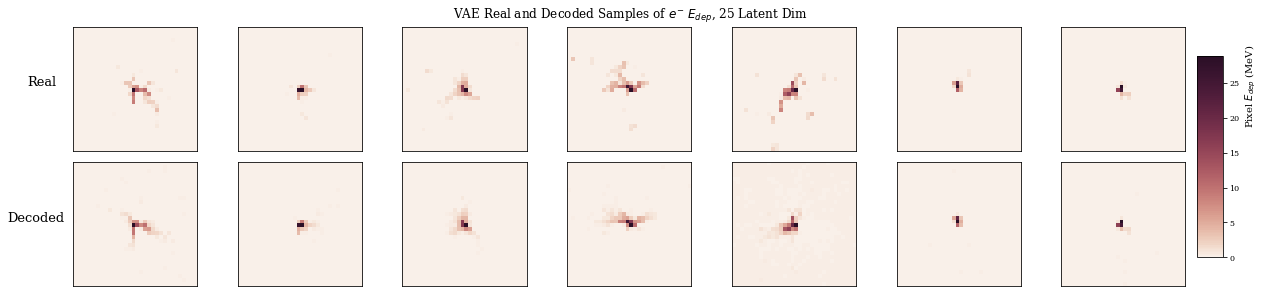

In [151]:
plot_reconstructions(model, save_dir=mydir, conv=False, simple=False, n=7, epoch = epoch)

(64, 32, 32)


Text(0.5,0.95,'Samples of Geant4 Electron Gun Energy Depositions')

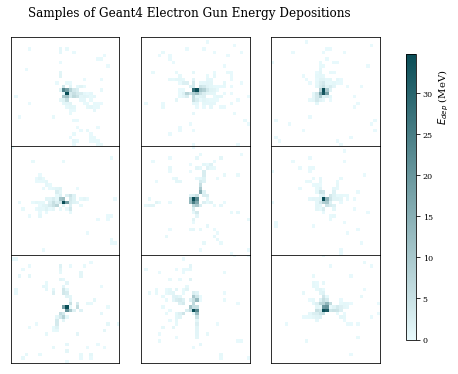

In [152]:
#THIS IS JUST A DIFFERENT WAY OF PLOTTING WHAT IS BELOW, BELOW IS MORE TIGHT LAYOUT


sample = torch.randn(64, zdim).to(device)
sample = model.decode(sample).cpu()
data = sample.view(64, 1, 32, 32).detach().numpy().squeeze()


columns = 3
rows = 3
etaran = (-50,50)
phiran = (-50,50)
extent = phiran + etaran
print data.shape
fig, axes =plt.subplots(rows,columns, figsize=(7, 6), sharex=True,sharey=True)

event_number = 0
plt.locator_params(axis='y', nbins=1)
plt.locator_params(axis='x', nbins=2)
#fig.xticks(rotation=45)
for i in range(rows):
    for j in range(columns):

        image_array = data[event_number ]

        image_array[image_array <= 0] = np.nan
        #cmap = sns.cubehelix_palette(dark = 0.4, light=0.95, gamma = 2.5, hue = 1, start =0, as_cmap=True)
        cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
        #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
        #cmap = sns.color_palette("BrBG",7)
        #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
      
        plt.axis('on')
        im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
        axes[i,j].set_xticklabels([])
        axes[i,j].set_yticklabels([])
        axes[i,j].xaxis.set_ticks_position('none')
        axes[i,j].yaxis.set_ticks_position('none')
        event_number +=1
#fig.tight_layout(rect=[0, 0, .9, 1])
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.66])

cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
#plt.tight_layout()
fig.subplots_adjust(wspace=0.00, hspace=0)
fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y=0.95)

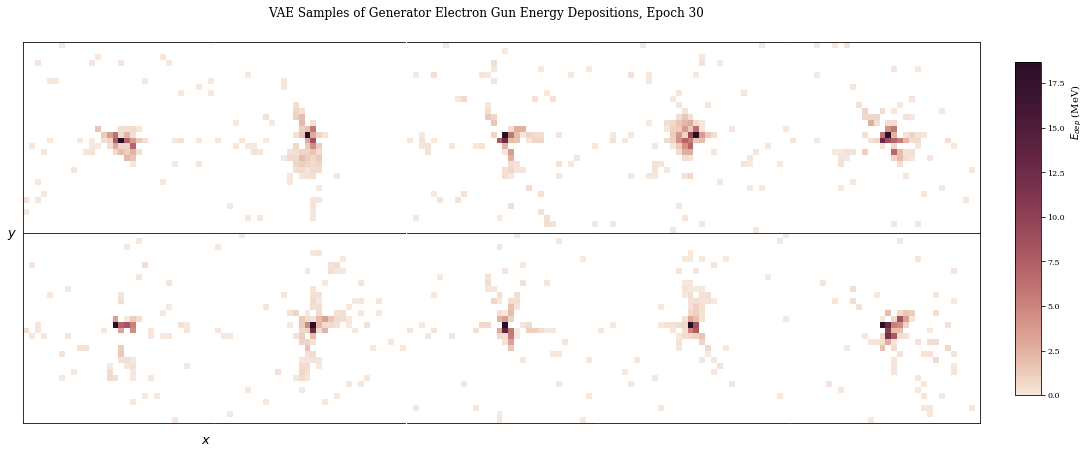

In [154]:
xran = (-50,50)
yran = (-50,50)
extent = xran + yran

rows  = 2
columns = 5

if rows <= 3 and columns <=5:
    scale_factor = 3.5
else:
    scale_factor = 2
    
real = False
if real == True:
    randints = np.random.randint(low = 0,high = normed_array.shape[0], size = 64)
    data = normed_array[randints].squeeze()
    #data= next(iter(test_loader))[0].detach().numpy().squeeze()
else:
    sample = torch.randn(64, zdim).to(device)
    sample = model.decode(sample).cpu()
    data = sample.view(64, 1, 32, 32).detach().numpy().squeeze()

fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
#print(len(axes))
event_number = 0
plt.locator_params(axis='y', nbins=1)
plt.locator_params(axis='x', nbins=2)
#fig.xticks(rotation=45)
for i in range(rows):
    for j in range(columns):

        #print(range(rows))
        image_array = data[event_number]

        image_array[image_array <= 0] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.965, gamma = 2.5, hue = 1, start =0, as_cmap=True)
        #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
        #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
        #cmap = sns.color_palette("BrBG",7)
        #img = ax.imshow(image_array[0], vmin = 0, extent=extent, origin='lower', cmap=cmap)
        #axes[i,j].set_aspect('equal')
        plt.axis('on')
        if rows == 1:
            #axes[j] = plt.subplot(gs1[i,j])
            if j != 0:
                axes[j].spines['left'].set_visible(False)
            else:
                axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
            axes[j].spines['top'].set_visible(False)
            axes[j].spines['right'].set_visible(False)
            #axes[j].spines['bottom'].set_visible(False)
            #axes[j].spines['left'].set_visible(False)
            #axes[j].set_aspect('equal')
            im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
            #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
            axes[j].set_xticklabels([])
            axes[j].set_yticklabels([])
            axes[j].xaxis.set_ticks_position('none')
            axes[j].yaxis.set_ticks_position('none')
            event_number +=1
        else:
            #axes[i,j].spines['top'].set_visible(False)
            axes[i,j].spines['bottom'].set_visible(True)
            if j!= 0:
                axes[i,j].spines['left'].set_visible(False)
            if i == range(rows)[-1] and j == 0:
                axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)

            if j == range(columns)[-1]:
                axes[i,j].spines['right'].set_visible(True)
            else:
                axes[i,j].spines['right'].set_visible(False)
            im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
            #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
            axes[i,j].set_xticklabels([])
            axes[i,j].set_yticklabels([])
            axes[i,j].xaxis.set_ticks_position('none')
            axes[i,j].yaxis.set_ticks_position('none')
            event_number +=1
#fig.tight_layout(rect=[0, 0, .9, 1])
cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
# fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
#fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
#plt.tight_layout()
fig.subplots_adjust(wspace=-0.085, hspace=0.00)
if real == True:
    fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y = 0.95)
else:
    fig.suptitle("VAE Samples of Generator Electron Gun Energy Depositions, Epoch " + str(epoch), y=0.95)

num_samples = rows * columns


#if save_dir != None:
 #   if real == True:
 #       type_string = "real"
 #   else:
 #       type_string = "fake"

    #learning_rate = '%.0E' % Decimal(lr)
    #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
    #filename = "VAE"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
    #                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
    #print(save_dir)
    #plt.savefig(save_dir + filename, bbox_inches='tight')


plt.show()

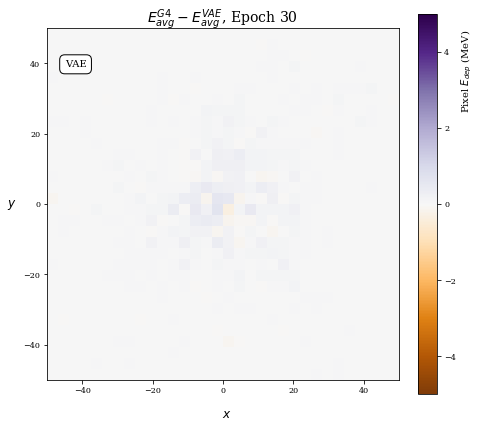

In [147]:
#this is to make the comparison of mean image over many samples to see how avergae distribution samples compare

data= next(iter(test_loader))

data = data[0].view([-1, 1024])
#data = Variable(data, volatile=True)
true_imgs = data
#print true_imgs.shape
decoded_imgs, _, _ = model.forward(data.to(device))

true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)

combined_fake_image = 0
for i in range(len(decoded_imgs)):
    combined_fake_image += decoded_imgs[i]
combined_fake_image = combined_fake_image / len(true_imgs)

combined_real_image = 0
for i in range(len(true_imgs)):
    combined_real_image += true_imgs[i]
combined_real_image = combined_real_image / len(true_imgs) 

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(combined_real_image - combined_fake_image, cmap ='PuOr', vmin = -5, vmax = 5, extent = extent)

cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
plt.title(r"$E_{avg}^{G4} - E_{avg}^{VAE}$, Epoch " + str(epoch), fontsize = 14)
plt.text(-45, 39, 'VAE', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
ax.xaxis.set_label_coords(0.51,-0.08)

ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
ax.yaxis.set_label_coords(-.1,0.48)